## Práctica 7: Red Neuronal Multiclase. Evaluacion detallada 

Grupo 5: Jorge Ortega y Daniela Vidal

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [13]:
def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0],[1, 0],[0, 1],[0, -1],[-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std) 

In [14]:
X, y, centers, classes, std = gen_blobs()
X.shape

(800, 2)

Vemos cuántos elementos hay en cada clase

In [15]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([134, 134, 133, 133, 133, 133]))

Como podemos observar están relativamente balanceadas, por lo que no hace falta hacer un tratamiento especial para equilibrarlas.

Separamos en un 60% de los datos para entrenamiento, 20% para validación y 20% para test.

In [16]:
X_train, X, y_train, y = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

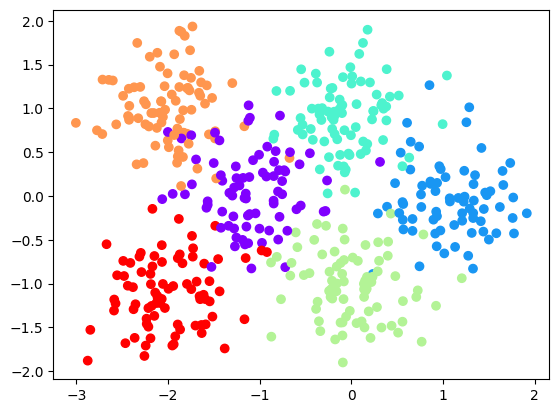

In [17]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='rainbow')

Tenemos datos que tienen un valor X y un valor Y que se asignan a una de 6 posibles clusters (del 0 al 5). El objetivo es predecir el cluster al que pertenece un punto. Por tanto es un problema de clasificación multiclase.

In [18]:
iters = 1000

# 1. Modelo complejo con muchas neuronas

Vamos a hacer un primer modelo con muchas neuronas para ver si es capaz de aprender los datos.
Tendrá 3 capas ocultas, la primera con 150 neuronas, la segunda con 50 y la última con 6, una por cada clase.

In [19]:
complex_model = Sequential(
    [Dense(units = 150,activation = 'relu'), 
     Dense(units = 50,activation = 'relu'), 
     Dense(units = 6,activation = 'linear')]
)

Las capas ocultas las hacemos con ReLu ya que este es el óptimo para este tipo de problemas. En la última neurona, al ser un problema de multi clasificación, usamos lineal con adam ya que es la combinación con la que mejor resultados obtuvimos en la práctica 6.

In [21]:
complex_model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer = Adam(learning_rate=1e-3),
    metrics = ['accuracy'])

complex_model.fit(X_train, y_train, epochs=iters, validation_data=(X_val, y_val), verbose = 0)

Precisión para los datos de entrenamiento:

In [22]:
c_m_f = tf.nn.softmax(complex_model(X_train), axis=1)
c_m_pred = tf.argmax(c_m_f, axis=1)

In [23]:
print("Train accuracy complex model: ", np.sum(c_m_pred == y_train)/len(y_train))

Train accuracy complex model:  0.9645833333333333


Precisión para los datos de test:

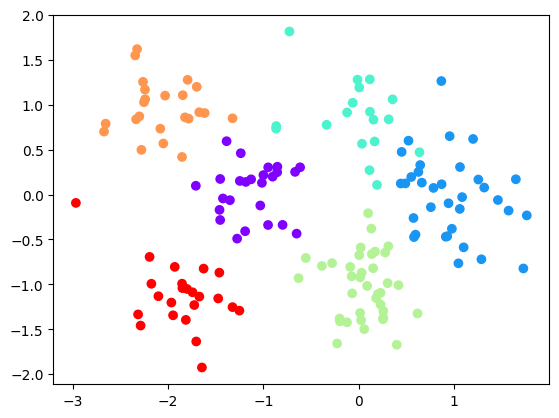

In [24]:
c_m_f = tf.nn.softmax(complex_model(X_test), axis=1)
c_m_pred = tf.argmax(c_m_f, axis=1)

plt.scatter(X_test[:,0], X_test[:,1], c=c_m_pred, cmap='rainbow')

In [25]:
print("Test accuracy complex model: ", np.sum(c_m_pred == y_test)/len(y_test))

Test accuracy complex model:  0.91875


# 2. Modelo simple con pocas neuronas

Vamos a hacer un primer modelo con pocas neuronas.
Tendrá 3 capas ocultas, la primera con 9 neuronas, la segunda con 7 y la última con 6, una por cada clase.

In [26]:
simple_model = Sequential(
    [Dense(units = 8,activation = 'relu'), 
     Dense(units = 7,activation = 'relu'), 
     Dense(units = 6,activation = 'linear')]
)

Dejaremos el resto de parámetros igual que en el modelo anterior para que la comparación de ambos sea únicamente por simple/complejo.

In [27]:
simple_model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer = Adam(learning_rate=1e-3),
    metrics = ['accuracy'])

simple_model.fit(X_train, y_train, epochs=iters, validation_data=(X_val, y_val), verbose = 0)

Precisión para los datos de entrenamiento:

In [28]:
s_m_f = tf.nn.softmax(simple_model(X_train), axis=1)
s_m_pred = tf.argmax(s_m_f, axis=1)

In [29]:
print("Train accuracy simple model: ", np.sum(s_m_pred == y_train)/len(y_train))

Train accuracy simple model:  0.925


Precisión para los datos de test:

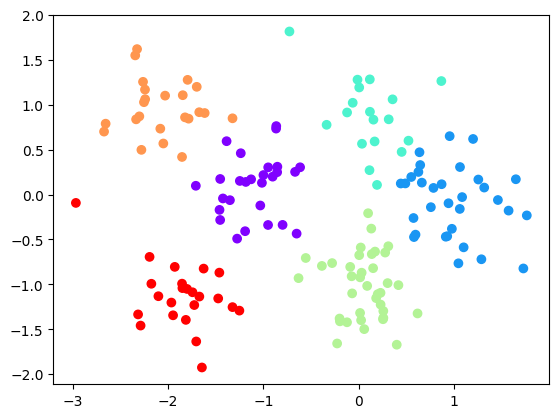

In [30]:
s_m_f = tf.nn.softmax(simple_model(X_test), axis=1)
s_m_pred = tf.argmax(s_m_f, axis=1)

plt.scatter(X_test[:,0], X_test[:,1], c=s_m_pred, cmap='rainbow')

In [31]:
print("Test accuracy simple model: ", np.sum(s_m_pred == y_test)/len(y_test))

Test accuracy simple model:  0.93125


# 3. Modelo complejo con regularización

Usaremos los mismos parámetros que en la compleja pero con regularización.

### 3.1 Primero averiguaremos el mejor valor para el parámetro de regularización

In [32]:
def parameter_decision(X_train, y_train, X_val, y_val, X_test, y_test):
    acc = list()
    lambdas = [0.001, 0.01, 0.1, 1]
    for l in lambdas:
        reg_model = Sequential(
            [Dense(units = 150,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l)),
            Dense(units = 50,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l)),
            Dense(units = 6,activation = 'linear')]
        )
        reg_model.compile(
            loss = SparseCategoricalCrossentropy(from_logits=True),
            optimizer = Adam(learning_rate=1e-3),)
        
        reg_model.fit(X_train, y_train, epochs=iters, validation_data=(X_val, y_val), verbose = 0)

        r_m_f = tf.nn.softmax(reg_model(X_test), axis=1)
        r_m_pred = tf.argmax(r_m_f, axis=1)
        aux = np.sum(r_m_pred == y_test)/len(y_test)
        acc.append(aux)
    return acc, lambdas

In [33]:
acc, lambdas = parameter_decision(X_train, y_train, X_val, y_val, X_test, y_test)

Visualizamos los datos

[0.925, 0.93125, 0.91875, 0.15625]

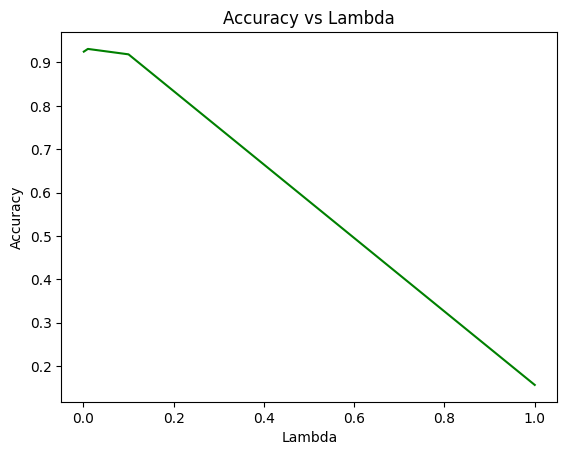

In [34]:
plt.plot(lambdas, acc, color="green")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Lambda")
acc

In [35]:
best_lambda = lambdas[np.argmax(acc)]
best_lambda

0.01

Aqui se puede observar el mejor valor para el parámetro de regularización.

In [36]:
reg_model = Sequential(
    [Dense(units = 150,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(best_lambda)),
    Dense(units = 50,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(best_lambda)),
    Dense(units = 6,activation = 'linear')]
)

In [37]:
reg_model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer = Adam(learning_rate=1e-3),
    metrics = ['accuracy'])

reg_model.fit(X_train, y_train, epochs=iters, validation_data=(X_val, y_val), verbose = 0)

Precisión para los datos de entrenamiento:

In [38]:
r_m_f = tf.nn.softmax(reg_model(X_train), axis=1)
r_m_pred = tf.argmax(r_m_f, axis=1)

In [39]:
print("Train accuracy regularized model: ", np.sum(r_m_pred == y_train)/len(y_train))

Train accuracy regularized model:  0.9208333333333333


Precisión para los datos de test:

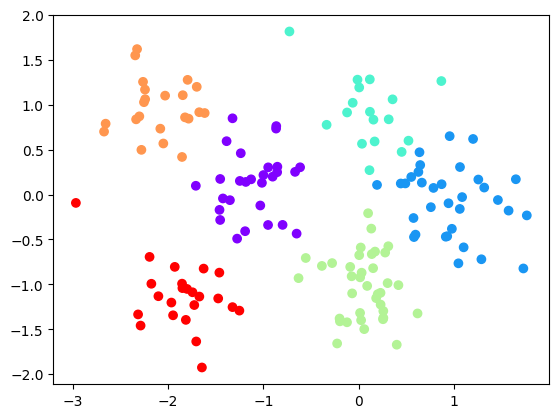

In [40]:
r_m_f = tf.nn.softmax(reg_model(X_test), axis=1)
r_m_pred = tf.argmax(r_m_f, axis=1)

plt.scatter(X_test[:,0], X_test[:,1], c=r_m_pred, cmap='rainbow')

In [41]:
print("Test accuracy regularized model: ", np.sum(r_m_pred == y_test)/len(y_test))

Test accuracy regularized model:  0.93125


# 5. Pintamos las curvas de aprendizaje de precisión y de pérdida según las iteraciones

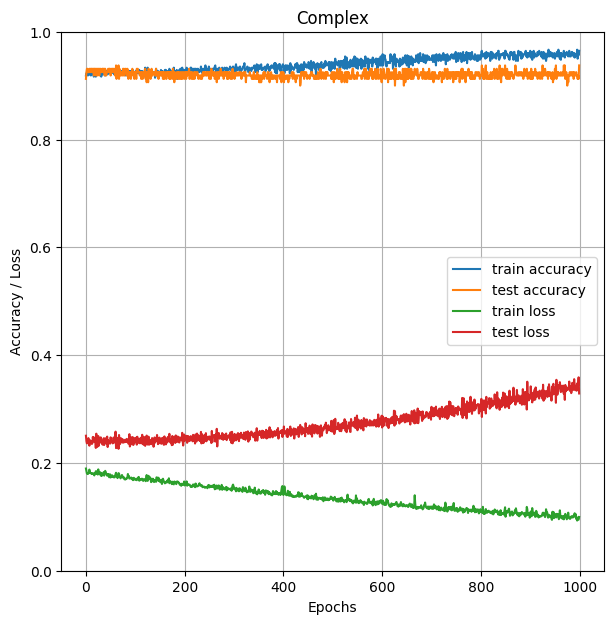

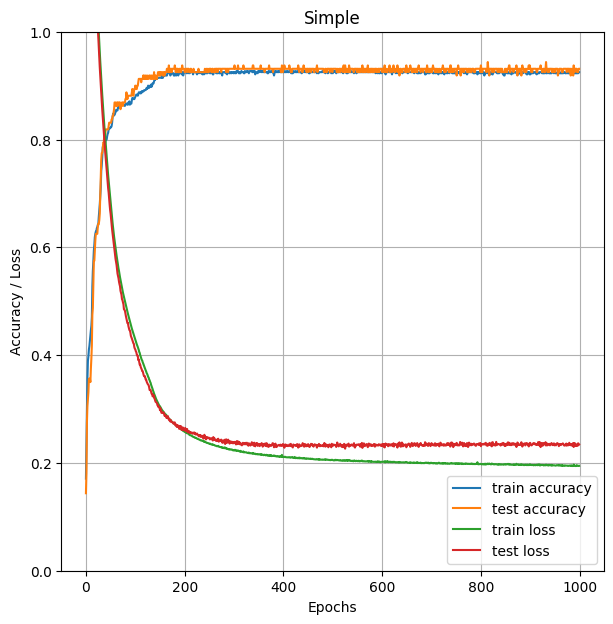

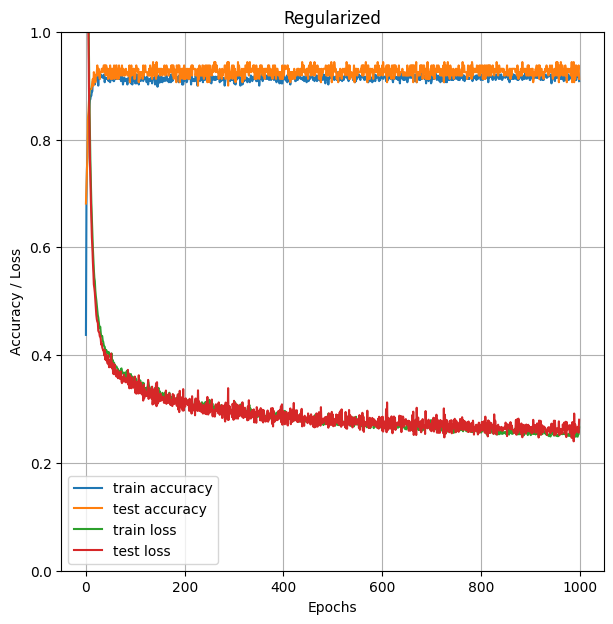

In [42]:
import pandas as pd

def plot_learning_curves(history, title):
    plt.figure(figsize=(7, 7))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label = 'test accuracy')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label = 'test loss')
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy / Loss")
    plt.gca().set_ylim(0,1)
    plt.title(title)
    plt.legend()
    plt.show()

plot_learning_curves(complex_model.history, "Complex")
plot_learning_curves(simple_model.history, "Simple")
plot_learning_curves(reg_model.history, "Regularized")


De estas gráficas podemos observar que:

Para el modelo complejo con menos de 50 iteraciones el error de validación empieza a subir drásticamente, por lo que es un buen momento para parar el entrenamiento. Vemos que si se elige más de 100 aproximadamente se produce overfitting, ya que la precisión de entrenamiento sube y la de test no sufre ninguna mejoría. En cuanto a la precision, se estabiliza antes de las 50 iteraciones. En general tiene una alta precisión tanto para entrenamiento como para test.

Para el modelo simple a partir de 100 aproximadamente, el error de validación empieza a subir y la pérdida se estabiliza, por lo que estas serían las iteraciones justas. Podemos ver que la precisión alcanza su máximo a partir de las 200 iteraciones. No se produce overfitting ya que en ningún caso la precisión de entrenamiento es mayor que la de test, esto cuadra con el hecho de que es un modelo simple.

Para el modelo regularizado el valor de "loss" para entrenamiento y para test no divergen notablemente y alcanzan su punto más bajo, que se pueda ver, en el 1000. No obstante no significa que haya que seguir entrenando ya que la precisión se estabiliza antes de las 200 iteraciones. Por último, su precisión es muy alta tanto para entrenamiento como para test, y no divergen notablemente. Entre otras cosas esto se debe a que los parámetros están regularizados y se puede ver, por la gráfica, como no sobreaprende.


# 4. Pintamos las curvas de aprendizaje de los modelos según el tamaño del conjunto de entrenamiento

In [43]:
def plot_learning_curves_set(title, sizes, train_errors, val_errors):
    plt.plot(sizes, train_errors, color="r", label="Training error")
    plt.plot(sizes, val_errors, color="b", label="Validation error")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("Error")
    
    plt.legend()
    plt.show()

In [50]:
def compute_learning_curves(title, model, X_train, y_train, X_val, y_val):
    train_errors, val_errors = [], []
    sizes = np.linspace(1, len(X_train), 15).astype(int)
    
    for m in sizes:
        model.compile(loss = SparseCategoricalCrossentropy(from_logits=True), optimizer = Adam(learning_rate=1e-3), metrics = ['accuracy']) 
        model.fit(X_train, y_train, batch_size = m, epochs = int(iters/10), validation_data=(X_val, y_val), verbose = 0)
    
        train_errors.append(model.evaluate(X_train[:m], y_train[:m], verbose = 0)[0])
        val_errors.append(model.evaluate(X_val, y_val, verbose = 0)[0])
    
    plot_learning_curves_set(title, sizes, train_errors, val_errors)    


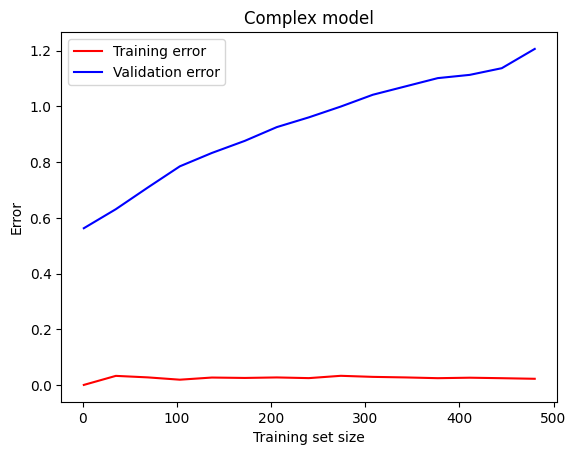

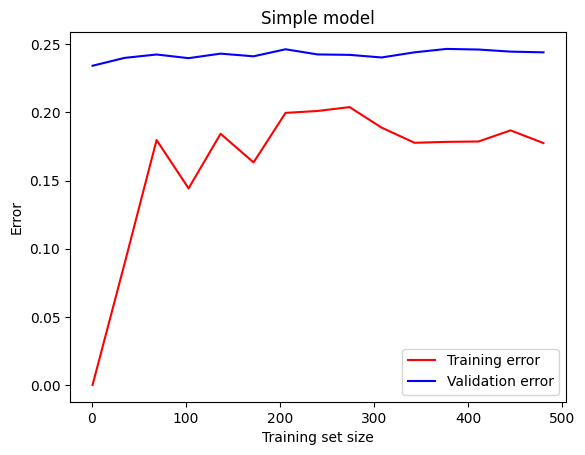

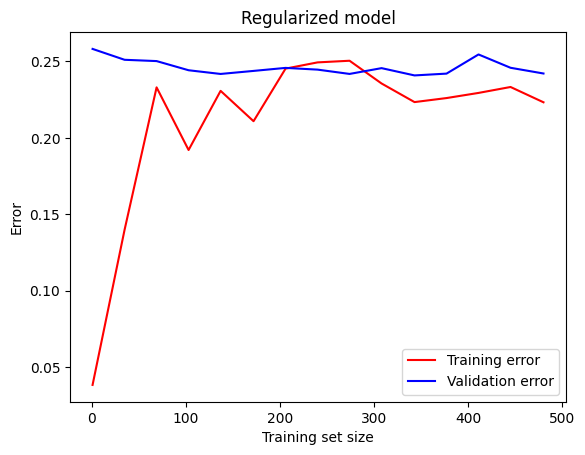

In [51]:
compute_learning_curves("Complex model", complex_model, X_train, y_train, X_val, y_val)
compute_learning_curves("Simple model", simple_model, X_train, y_train, X_val, y_val)
compute_learning_curves("Regularized model", reg_model, X_train, y_train, X_val, y_val)

En las graficas de de las curvas de aprendizaje mediante el tamaño de los datos de entrenamiento, podemos observar que la curva del modelo complejo, el error de validacion sube de manera uniforme conforme suben el numero de datos del conjunto, mientras que el error de entrenamiento de esta es muy bajo y se mantiene constante. Esto nos indica que el modelo complejo esta sobreajustado a los datos de entrenamiento, por lo que no es capaz de generalizar bien a los datos de test.

Por otro lado, el modelo simple, el error de entrenamiento sube cuando hay pocos datos de manera bastante drastica, mientras que conforme aumentan mas ese numero de datos (a partir del rango 80-100), el error pese a tener algunas alteraciones hacia arriba y hacia abajo, se mantiene constante. Esto nos indica que el modelo simple no esta sobreajustado a los datos de entrenamiento, por lo que es capaz de generalizar bien a los datos de test. El error de validacion en cambio es constante y muy alto desde el principio, lo que nos indica que el modelo simple no es capaz de aprender los datos de entrenamiento.

Por ultimo el modelo complejo con regularizacion asciende de manera muy brusca cuando hay pocos datos de entrenamiento hasta llegar a valores mmuy altos, pero conforme aumentan el numero de datos, el error de entrenamiento se mantiene un poco mas constante pese a seguir teniendo variaciones en él tanto hacia arriba (mayor error) como hacia abajo (menor error) a partir del tamaño 50 y el error de validacion sube de manera uniforme. Esto nos indica que el modelo complejo con regularizacion no esta sobreajustado a los datos de entrenamiento, por lo que es capaz de generalizar bien a los datos de test. En este modelo el error de validacion y el de entrenamiento llegan a estar muy cerca, lo que nos indica que el modelo complejo con regularizacion es el que mejor generaliza a los datos de test.

# 6. CONCLUSIONES

Se puede ver que en el complejo con 1000 iteraciones se obtiene un 94% de precisión en el conjunto de entrenamiento y un 92% en el de test, por lo que se puede decir que hay overfitting, esto es esperaable ya que el modelo es muy complejo para los datos.

En el modelo simple con 1000 iteraciones se obtiene un 92% de precisión en el conjunto de entrenamiento y un 93% en el de test, por lo que se puede decir que no hay overfitting, esto son bastante buenos resultados ya que se trata de un modelo demasiado simple para estos datos.

En el modelo regularizado con 1000 iteraciones se obtiene un 92% de precisión en el conjunto de entrenamiento y un 92% en el de test, por lo que se puede decir que no hay overfitting, ademas se puede observar que el error de validación es menor que en el modelo simple, por lo que se puede decir que el modelo regularizado es mejor que el modelo simple.

Estos resultados son los esperados para cada tipo de red habiendo visto las gráficas.